/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Batch2/DRG123/H&EStain/Train/models/heDRG123_9masks_RN2
>>> GPU activated? NO
Prediction Complete in 389.50 seconds
CSV file stored in /media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/DRG Full Images/H&EStain/TG1/csv


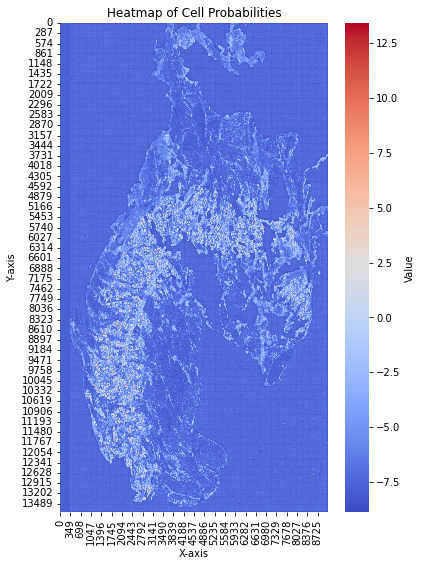

In [19]:
#INPUTS: Must have a pretrained model and a directory of image(s) for prediction
#OUTPUTS: Default cellpose segmentation npy and roi.zip outputs, custom csv for further evaluation and visualization, and heat map of cell probabilities (-10, 10)
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import re
import cv2
from PIL import Image
from glob import glob
from read_roi import read_roi_file, read_roi_zip
from cellpose import core, utils, io, models, metrics, plot, train
import time
import svgwrite
import seaborn as sns

def save_rois_with_conversion(masks, files, output_dir, image_format):
    # Ensure all masks are in the correct format
    masks = [mask.astype(np.uint16) if mask.dtype != np.uint16 else mask for mask in masks]
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    count = 0
    for file, mask in zip(files, masks):
        count += 1
        output_path = os.path.join(output_dir, file.split('/')[-1].replace(image_format,''))
        io.save_rois(mask, output_path)

def zip_to_csv(directory):
    for filename in [i for i in os.listdir(directory) if '.zip' in i]:
        df_data = {'Name': [], 'X': [], 'Y': []}
        file_path = os.path.join(directory, filename)
        data = read_roi_zip(file_path)
        for name, roi in data.items():
            df_data['X'].extend(roi['x'])
            df_data['Y'].extend(roi['y'])
            for i in range(len(roi['x'])):
                df_data['Name'].append(str(roi['name']))
        df = pd.DataFrame.from_dict(df_data)
        out_dir = os.path.join(directory, 'csv')
        os.makedirs(out_dir, exist_ok=True)
        df.to_csv(os.path.join(out_dir, filename).replace('.zip','.csv').replace('_rois',''), sep=',', index=False, header=True)

#PRETRAINED MODEL
model_name = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Batch2/DRG123/H&EStain/Train/models/heDRG123_9masks_RN2'
print(model_name)
#FOLDER WITH DESIRED IMAGE(S)
#Crop if cellpose cannot directly run the image
dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/DRG Full Images/H&EStain/TG1'

flow_threshold=0.4
cellprob_threshold=0

diameter = 0

#output paths of roi image, probability heatmap
roi_out_dir = dir
heatmap_out_dir = dir
image_format = '.tif'

#outputting the visuals take ~10 minutes and are optional
output_visuals = True

start_time = time.time()
    
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

files = io.get_image_files(dir, '_masks')
images = [io.imread(f) for f in files]

model = models.CellposeModel(gpu=True, model_type=model_name)

diameter = model.diam_labels if diameter==0 else diameter
    
masks, flows, styles = model.eval(images,
                                    channels=[1, 0],
                                  diameter=diameter,
                                  flow_threshold,
                                  cellprob_threshold
                                  )
    
io.masks_flows_to_seg(images,
                        masks,
                      flows,
                      files,
                      channels=[1, 0],
                      diams=diameter*np.ones(len(masks)),
                      )

save_rois_with_conversion(masks, files, dir, image_format)
    
zip_to_csv(dir)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Prediction Complete in {elapsed_time:.2f} seconds')


print(f"CSV file stored in {os.path.join(dir, 'csv')}")

if (output_visuals):
    for i in range(len(flows)):
        # Example 2D array (replace this with your actual data)
        data = flows[i][2]
        
        # Get the shape of the data
        height, width = data.shape
            
        # Define a base figure size, adjusting for large dimensions
        scaling_factor = (min(height, width))/6  # Adjust this to control the overall size
        fig_width = int(width/scaling_factor)
        fig_height = int(height/scaling_factor)
            
        # Create the figure with the calculated size
        plt.figure(figsize=(fig_width, fig_height))
            
        # Create the heatmap
        sns.heatmap(data, cmap="coolwarm", annot=False, fmt=".2f", cbar_kws={'label': 'Value'})
            
        # Labels and title
        plt.title("Heatmap of Cell Probabilities")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
            
            # Save as TIF
        plt.savefig(os.path.join(heatmap_out_dir, files[i].split('/')[-1].replace(image_format,'_heatmap.tif')), format="tif", bbox_inches="tight", dpi=300)
            
            # Show the plot
        plt.show()